## Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# Models
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


## Load the Dataset

In [2]:
df = pd.read_csv('../Data/for_ml_df.csv').drop("Unnamed: 0", axis=1)
df.head()

,Gender_F,Gender_M,Discipline_CNF,Discipline_CWT,Discipline_CWTB,Discipline_FIM,Card_RED,Card_WHITE,Card_YELLOW,Remarks_RED,...,Event Type_World Championship,Event Type_Worldrecord attempt,AP,RP,Depth_Difference,Points,Month,Year,Experience Dive,Experience Discipline
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,61.0,61.0,0.0,61.0,6.0,1994.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,72.0,72.0,0.0,72.0,9.0,1995.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,62.0,62.0,0.0,62.0,10.0,1996.0,1.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,72.0,72.0,0.0,72.0,10.0,1996.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,73.0,73.0,0.0,73.0,8.0,1997.0,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26700 entries, 0 to 26699
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender_F                        26700 non-null  float64
 1   Gender_M                        26700 non-null  float64
 2   Discipline_CNF                  26700 non-null  float64
 3   Discipline_CWT                  26700 non-null  float64
 4   Discipline_CWTB                 26700 non-null  float64
 5   Discipline_FIM                  26700 non-null  float64
 6   Card_RED                        26700 non-null  float64
 7   Card_WHITE                      26700 non-null  float64
 8   Card_YELLOW                     26700 non-null  float64
 9   Remarks_RED                     26700 non-null  float64
 10  Remarks_Syncope                 26700 non-null  float64
 11  Remarks_WHITE                   26700 non-null  float64
 12  Remarks_YELLOW                  

No null data which was expected, as it's our prepared for ml dataset.

In [4]:
df.columns

Index(['Gender_F', 'Gender_M', 'Discipline_CNF', 'Discipline_CWT',
       'Discipline_CWTB', 'Discipline_FIM', 'Card_RED', 'Card_WHITE',
       'Card_YELLOW', 'Remarks_RED', 'Remarks_Syncope', 'Remarks_WHITE',
       'Remarks_YELLOW', 'Remarks_nan', 'Event Type_Competition',
       'Event Type_Depth Competition', 'Event Type_Mixed Competition',
       'Event Type_Pool Competition', 'Event Type_Team Competition',
       'Event Type_World Championship', 'Event Type_Worldrecord attempt', 'AP',
       'RP', 'Depth_Difference', 'Points', 'Month', 'Year', 'Experience Dive',
       'Experience Discipline'],
      dtype='object')

# Machine Learning

## Heatmap

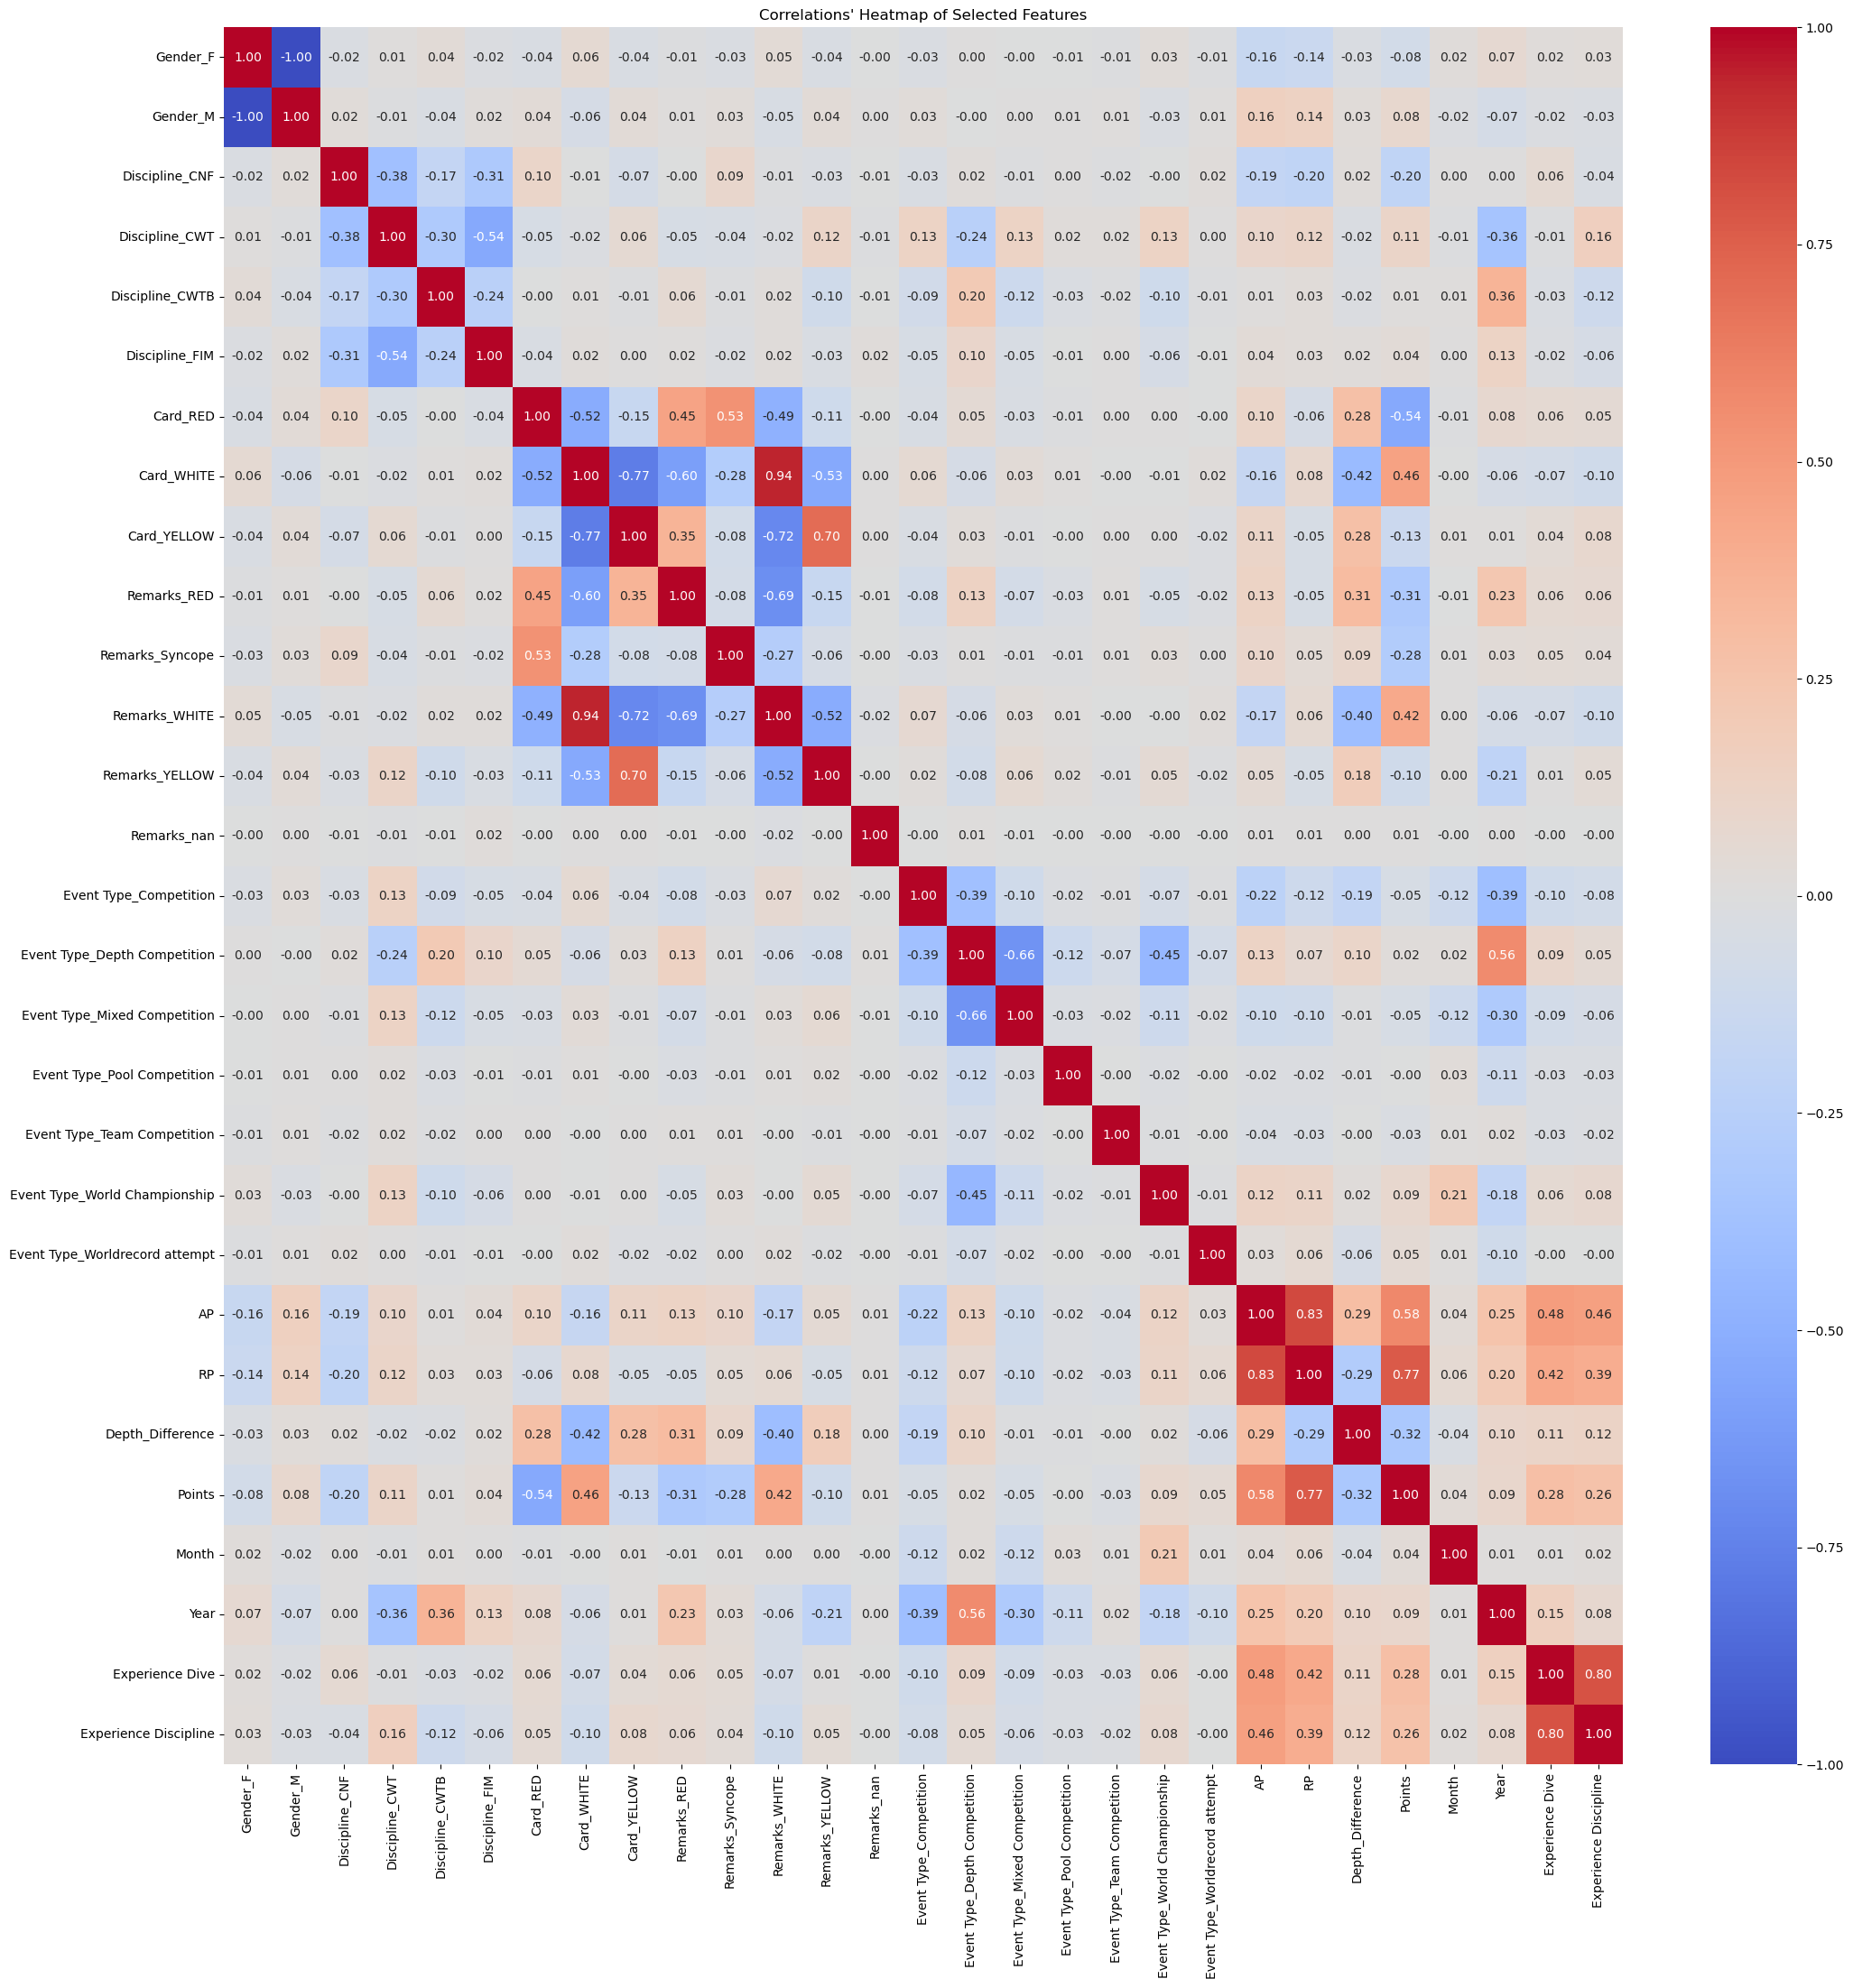

In [5]:
# Calculating the correlation matrix
correlation_matrix = df.corr()

# Plotting the heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlations' Heatmap of Selected Features")
plt.show()


Without going in details, we can't see interesting correlations between features that we didn't suspected to be correlated (like AP, RP and Points for example).

This makes our data suitable for clustering algorithms.

Here are more detailled analysis of the heatmap :

- Gender:

There are two gender categories, represented as Gender_F for female and Gender_M for male. They have a perfect negative correlation (-1) with each other, which is expected since they are mutually exclusive binary indicators.


- Discipline:

Several disciplines are listed (CNF, CMT, CMTB, FIN), and they show varying degrees of negative correlations with each other. This suggests that these are also mutually exclusive categories, which seems logical because they have different rules.


- Card Color: 

Card_RED and Card_WHITE are two categories that are also mutually exclusive, indicated by a perfect negative correlation of -1, which is totally expected.


- Academic Performance (AP): 

The feature AP has a moderately positive correlation with Experience_Dive (0.48) and Experience_Discipline (0.46), suggesting that divers tends to go deeper with more experience in diving or in a specific discipline, which make sense.


- Experience: 

The Experience_Dive and Experience_Discipline features have a very high positive correlation with each other (0.80), indicating that as experience in one increases, experience in the other tends to increase as well, which can mean that divers tends to stay in the same discpline.


- No Strong Correlations with Gender: 

Both Gender_F and Gender_M show very weak correlations with other features, suggesting that gender does not have a strong linear relationship with the other measured variables.


- Discipline Correlations: 

The discipline features show strong negative correlations with each other, especially Discipline_CMT and Discipline_FIN (-0.54), which suggests that they are distinct categories within the dataset.

- Experience and Card Color: 

There's a moderately negative correlation between Card_WHITE and both Experience_Dive and Experience_Discipline (-0.52 and -0.50, respectively). This could indicate that more experienced individuals are less likely to have a "white" card, which might represent that experienced divers tends to overestimate their skills, and got a yellow card because of that (with RP < AP).

## Clustering

In [13]:
df.columns

Index(['Gender_F', 'Gender_M', 'Discipline_CNF', 'Discipline_CWT',
       'Discipline_CWTB', 'Discipline_FIM', 'Card_RED', 'Card_WHITE',
       'Card_YELLOW', 'Remarks_RED', 'Remarks_Syncope', 'Remarks_WHITE',
       'Remarks_YELLOW', 'Remarks_nan', 'Event Type_Competition',
       'Event Type_Depth Competition', 'Event Type_Mixed Competition',
       'Event Type_Pool Competition', 'Event Type_Team Competition',
       'Event Type_World Championship', 'Event Type_Worldrecord attempt', 'AP',
       'RP', 'Depth_Difference', 'Points', 'Month', 'Year', 'Experience Dive',
       'Experience Discipline'],
      dtype='object')

In [23]:
selected_features = [
    'Discipline_CNF',
    'Discipline_CWT',
    'Discipline_CWTB',
    'Discipline_FIM',
    'AP',
    'Month',
    'Year',
    'Experience Dive',
    'Experience Discipline'
]

#### 1. KMeans

In [24]:
# Function to perform K-means clustering and plot Elbow curve
def kmeans_clustering_and_elbow_plot(data, features):
    # Scaling the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[features])

    # Calculating WCSS (Within-Cluster Sum of Square)
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init='auto', random_state=42)
        kmeans.fit(scaled_data)
        wcss.append(kmeans.inertia_)

    # Plotting the Elbow Method graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    return wcss

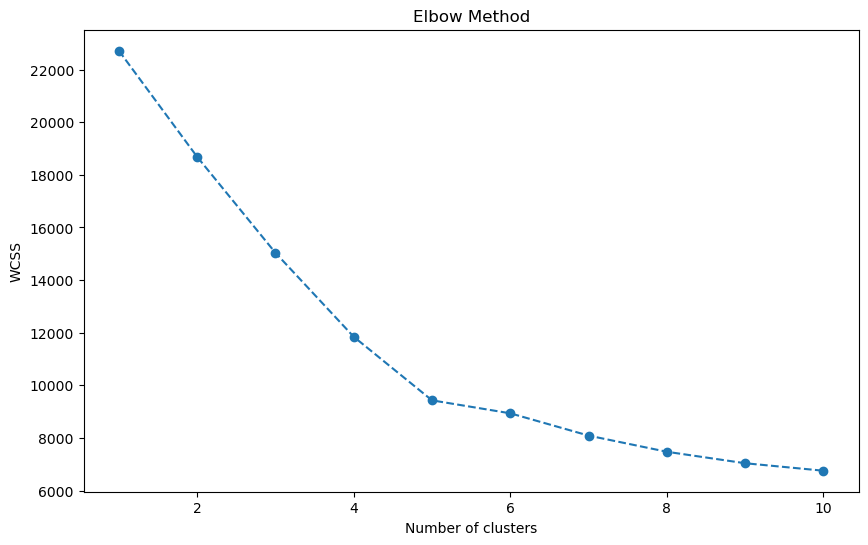

In [25]:
# Clustering for dives with RED card
wcss_red = kmeans_clustering_and_elbow_plot(df[df['Card_RED'] == 1], selected_features)

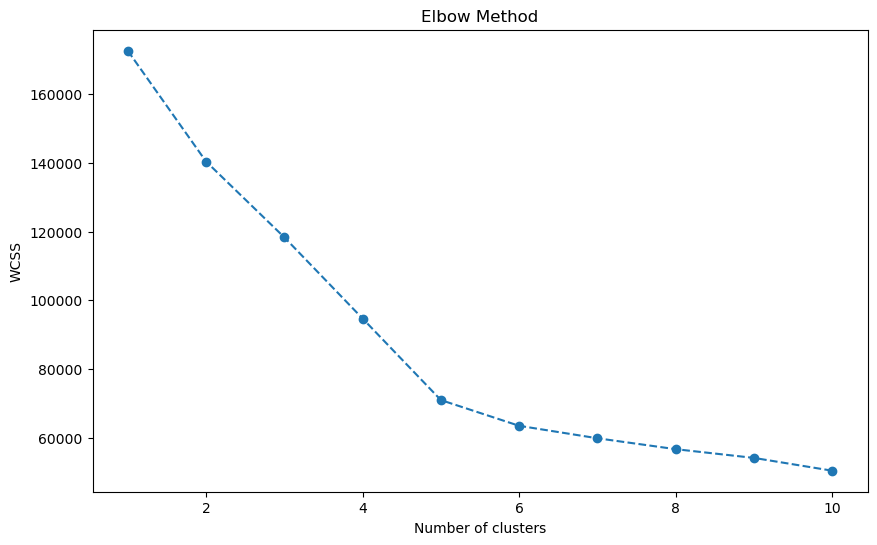

In [26]:
# Clustering for dives with WHITE card
wcss_white = kmeans_clustering_and_elbow_plot(df[df['Card_WHITE'] == 1], selected_features)

In [29]:
# Filtering data for Red Card and White Card
red_card_data = df[df['Card_RED'] == 1][selected_features]
white_card_data = df[df['Card_WHITE'] == 1][selected_features]

# Performing KMeans clustering with k = 5
kmeans_red = KMeans(n_clusters=5, n_init='auto', random_state=42).fit(red_card_data)
kmeans_white = KMeans(n_clusters=5, n_init='auto', random_state=42).fit(white_card_data)

# Adding cluster labels to the dataframes
red_card_data['Cluster'] = kmeans_red.labels_
white_card_data['Cluster'] = kmeans_white.labels_

# Displaying a summary of the clusters for each group
red_clusters_summary = red_card_data['Cluster'].value_counts()
white_clusters_summary = white_card_data['Cluster'].value_counts()

print(red_clusters_summary, white_clusters_summary)


Cluster
1    903
3    617
4    594
0    312
2     98
Name: count, dtype: int64 Cluster
3    7101
0    6532
4    3126
2    1446
1     981
Name: count, dtype: int64


Plongées avec un carton Rouge (Red Card):

Cluster 0: 417 plongées |
Cluster 1: 482 plongées |
Cluster 2: 792 plongées |
Cluster 3: 833 plongées |

Plongées avec un carton Blanc (White Card):

Cluster 0: 3367 plongées | 
Cluster 1: 7124 plongées |
Cluster 2: 6906 plongées |
Cluster 3: 1792 plongées |

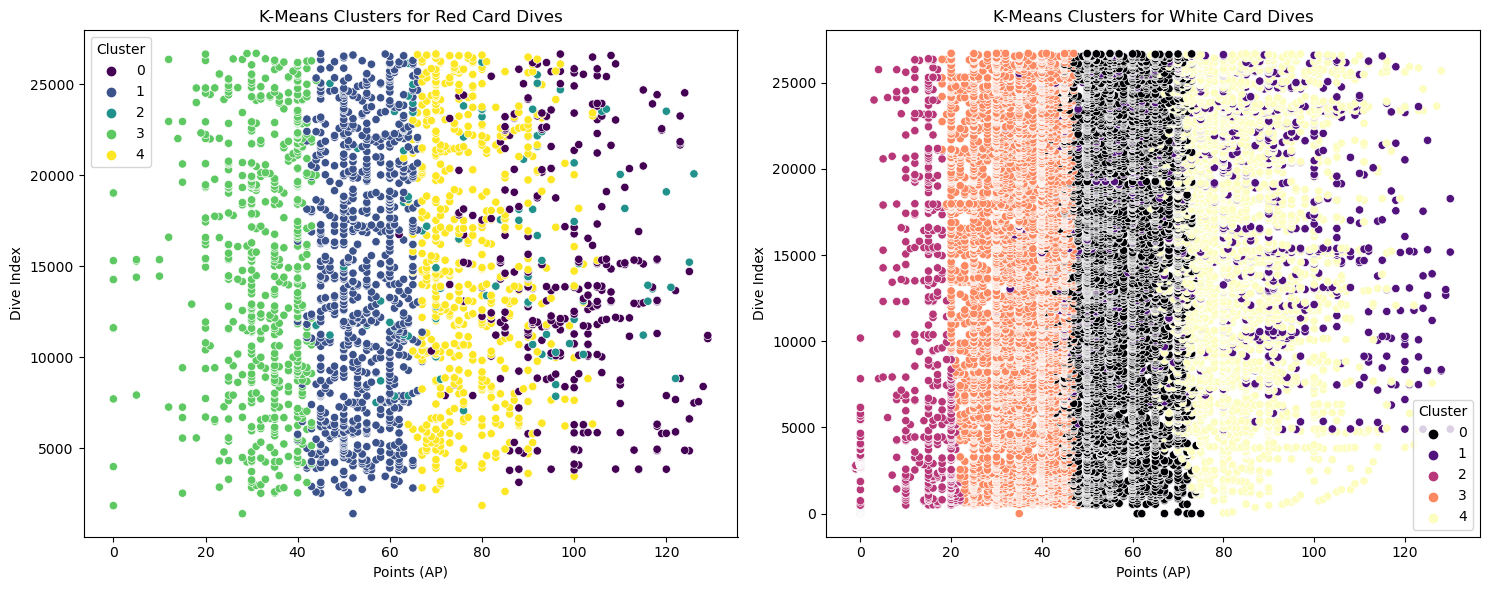

In [30]:
# Plotting the clusters for Red Card and White Card data
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for Red Card data
sns.scatterplot(ax=axes[0], x=red_card_data['AP'], y=red_card_data.index, 
                hue=red_card_data['Cluster'], palette='viridis', legend='full')
axes[0].set_title('K-Means Clusters for Red Card Dives')
axes[0].set_xlabel('Points (AP)')
axes[0].set_ylabel('Dive Index')

# Plot for White Card data
sns.scatterplot(ax=axes[1], x=white_card_data['AP'], y=white_card_data.index, 
                hue=white_card_data['Cluster'], palette='magma', legend='full')
axes[1].set_title('K-Means Clusters for White Card Dives')
axes[1].set_xlabel('Points (AP)')
axes[1].set_ylabel('Dive Index')

plt.tight_layout()
plt.show()


Segmentation claire : J'ai pu identifier des segments distincts au sein des plongées, ce qui pourrait aider à comprendre des groupes spécifiques ou des comportements au sein de ces plongées.

Simplicité et efficacité : La méthode K-means est simple à comprendre et à mettre en œuvre. Elle est également efficace en termes de calcul, ce qui la rend adaptée à des ensembles de données de grande taille comme le vôtre.

Identification des tendances : Cette méthode m'a permis d'observer des tendances et des patterns au sein des données, en particulier en ce qui concerne la relation entre les disciplines de plongée, les points obtenus, et le type de carton reçu.

#### 2. DBSCAN

In [32]:
# Filtrage des données pour les plongées avec carton rouge et blanc
data_red = df[df['Card_RED'] == 1][selected_features]
data_white = df[df['Card_WHITE'] == 1][selected_features]

# Normalisation des données
scaler = StandardScaler()
data_red_scaled = scaler.fit_transform(data_red)
data_white_scaled = scaler.fit_transform(data_white)

# Afficher les dimensions des données filtrées et normalisées
data_red_scaled.shape, data_white_scaled.shape


((2524, 9), (19186, 9))

K-Distance Graph for Dives with Red Card:


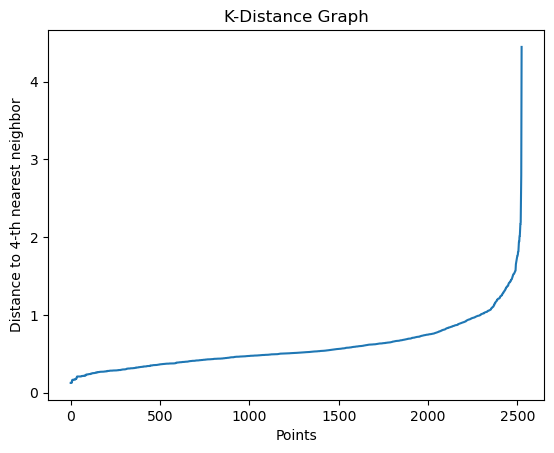

K-Distance Graph for Dives with White Card:


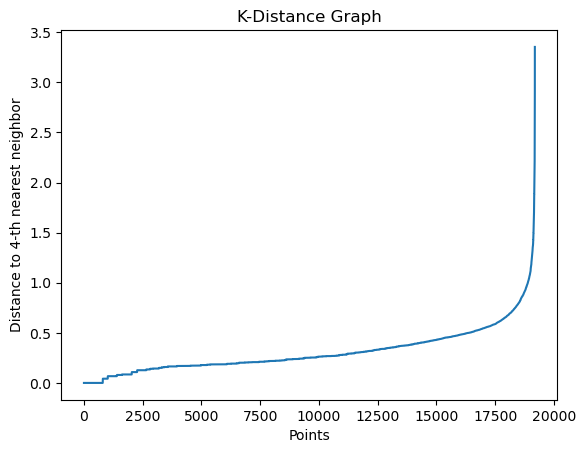

In [33]:
def plot_k_distance(data, k=4):
    """
    Plot the distance to the k-th nearest neighbor for each point in the dataset.
    This helps to determine a good value for 'eps' in DBSCAN.
    """
    # Calcul de la distance au k-ième voisin le plus proche pour chaque point
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)

    # Trier les distances
    sorted_distances = np.sort(distances[:, k-1], axis=0)

    # Tracer le graphique
    plt.plot(sorted_distances)
    plt.xlabel('Points')
    plt.ylabel('Distance to {}-th nearest neighbor'.format(k))
    plt.title('K-Distance Graph')
    plt.show()

# Tracer le graphique de la distance k-ème pour les plongées avec carton rouge
print("K-Distance Graph for Dives with Red Card:")
plot_k_distance(data_red_scaled)

# Tracer le graphique de la distance k-ème pour les plongées avec carton blanc
print("K-Distance Graph for Dives with White Card:")
plot_k_distance(data_white_scaled)


In [34]:
# Paramètres DBSCAN
eps_red = 1
eps_white = 0.05
min_samples = 5  # Un choix commun pour min_samples

# Application de DBSCAN aux plongées avec carton rouge
dbscan_red = DBSCAN(eps=eps_red, min_samples=min_samples)
clusters_red = dbscan_red.fit_predict(data_red_scaled)

# Application de DBSCAN aux plongées avec carton blanc
dbscan_white = DBSCAN(eps=eps_white, min_samples=min_samples)
clusters_white = dbscan_white.fit_predict(data_white_scaled)

# Calcul du nombre de clusters et de points de bruit pour chaque ensemble
n_clusters_red = len(set(clusters_red)) - (1 if -1 in clusters_red else 0)
n_noise_points_red = list(clusters_red).count(-1)

n_clusters_white = len(set(clusters_white)) - (1 if -1 in clusters_white else 0)
n_noise_points_white = list(clusters_white).count(-1)

(n_clusters_red, n_noise_points_red), (n_clusters_white, n_noise_points_white)


((5, 180), (78, 18373))

Pour les plongées avec un carton rouge :

Nombre de clusters formés : 5 |
Nombre de points considérés comme du bruit : 29 |

Pour les plongées avec un carton blanc :

Nombre de clusters formés : 14 |
Nombre de points considérés comme du bruit : 25 |

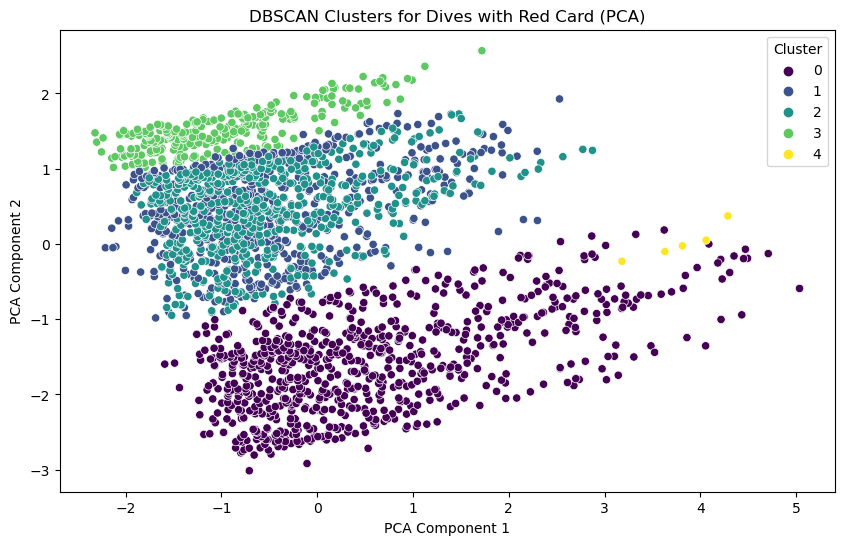

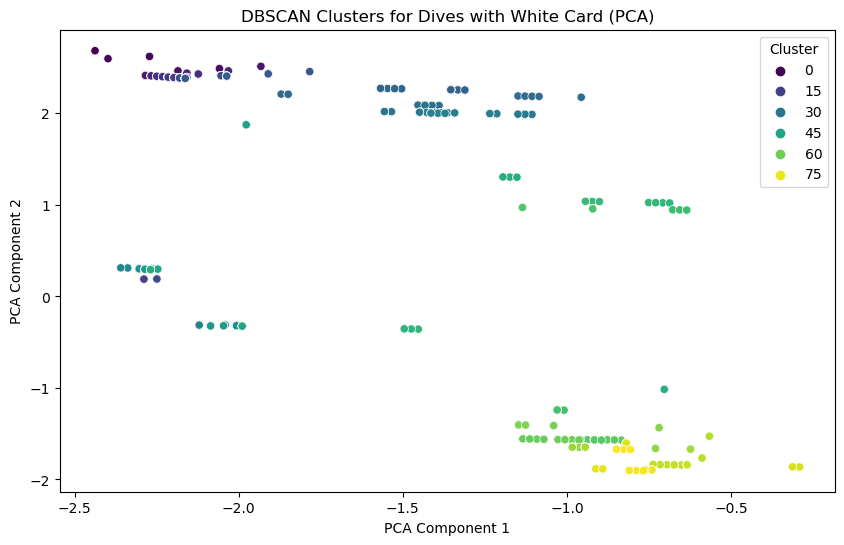

In [35]:
def apply_pca_and_plot_clusters(data, clusters, title):
    """
    Apply PCA to reduce data to two dimensions and plot the clusters.
    """
    # Réduction de dimensionnalité avec PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)

    # Création d'un DataFrame pour la visualisation
    plot_data = pd.DataFrame(data_pca, columns=['PCA1', 'PCA2'])
    plot_data['Cluster'] = clusters

    # Filtration pour enlever les points de bruit
    plot_data_filtered = plot_data[plot_data['Cluster'] != -1]

    # Tracé des clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=plot_data_filtered, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

# Visualisation des clusters après réduction de dimensionnalité pour les plongées avec carton rouge
apply_pca_and_plot_clusters(data_red_scaled, clusters_red, "DBSCAN Clusters for Dives with Red Card (PCA)")

# Visualisation des clusters après réduction de dimensionnalité pour les plongées avec carton blanc
apply_pca_and_plot_clusters(data_white_scaled, clusters_white, "DBSCAN Clusters for Dives with White Card (PCA)")


Pour les plongées avec un carton rouge,on peut observer comment les plongées sont regroupées en différents clusters. Il semble y avoir une certaine séparation entre les groupes.

Pour les plongées avec un carton blanc, les clusters sont plus nombreux et plus dispersés, reflétant la variété dans les données de ces plongées.

# Classification


In [36]:
df.columns

Index(['Gender_F', 'Gender_M', 'Discipline_CNF', 'Discipline_CWT',
       'Discipline_CWTB', 'Discipline_FIM', 'Card_RED', 'Card_WHITE',
       'Card_YELLOW', 'Remarks_RED', 'Remarks_Syncope', 'Remarks_WHITE',
       'Remarks_YELLOW', 'Remarks_nan', 'Event Type_Competition',
       'Event Type_Depth Competition', 'Event Type_Mixed Competition',
       'Event Type_Pool Competition', 'Event Type_Team Competition',
       'Event Type_World Championship', 'Event Type_Worldrecord attempt', 'AP',
       'RP', 'Depth_Difference', 'Points', 'Month', 'Year', 'Experience Dive',
       'Experience Discipline'],
      dtype='object')

In [37]:
selected_features = [
    'Discipline_CNF',
    'Discipline_CWT',
    'Discipline_CWTB',
    'Discipline_FIM',
    'AP',
    'Month',
    'Year',
    'Experience Dive',
    'Experience Discipline'
]

#### SVM 

#### Justification des Choix
Choix des caractéristiques (features) : Les caractéristiques sélectionnées sont centrées sur les disciplines de la plongée et l'apnée (AP), ce qui semble pertinent pour prédire le type de carton reçu. Ces caractéristiques sont susceptibles d'avoir un impact direct sur la performance du plongeur et, par conséquent, sur le type de carton attribué.

Utilisation de SVM avec différents noyaux : SVM est un choix robuste pour la classification, capable de gérer à la fois des données linéaires et non linéaires. Les différents noyaux (linéaire, polynomial, RBF, sigmoid) permettent d'explorer diverses manières de séparer les données dans l'espace des caractéristiques. Le choix de tester différents noyaux est motivé par le désir de trouver la meilleure frontière de décision pour nos données spécifiques.

In [48]:
X = df[selected_features]
y = df[['Card_RED', 'Card_WHITE', 'Card_YELLOW']]


# Séparer les données en ensembles d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Entraîner des modèles SVM avec différents noyaux
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
models = {}
for kernel in kernels:
    model = SVC(kernel=kernel)
    model.fit(X_train, y_train)
    models[kernel] = model

# Évaluer les modèles
performance = {}
for kernel, model in models.items():
    y_pred = model.predict(X_test)
    performance[kernel] = classification_report(y_test, y_pred)


ValueError: y should be a 1d array, got an array of shape (21360, 3) instead.

In [49]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Assuming df and selected_features are already defined and correct
X = df[selected_features]
y = df[['Card_RED', 'Card_WHITE', 'Card_YELLOW']]

# Séparer les données en ensembles d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner des modèles SVM avec différents noyaux
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
models = {}
for kernel in kernels:
    # Wrap the SVC model with OneVsRestClassifier
    model = OneVsRestClassifier(SVC(kernel=kernel))
    model.fit(X_train, y_train)
    models[kernel] = model

# Évaluer les modèles
performance = {}
for kernel, model in models.items():
    y_pred = model.predict(X_test)
    performance[kernel] = classification_report(y_test, y_pred, output_dict=True)  # Use output_dict=True to handle multi-label output


c:\Users\ximvi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ximvi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ximvi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ximvi\anaconda3\Lib\site-packages\sklearn\metr

In [51]:
# Créer un DataFrame vide pour les résultats
results_df = pd.DataFrame(columns=['Model', 'Class', 'Precision', 'Recall', 'F1-Score'])

# Parser les résultats du dictionnaire et les ajouter au DataFrame
for model, metrics in performance.items():
    for class_name, class_metrics in metrics.items():
        # Skip the 'accuracy' as it is a single value, not a dict
        if class_name == 'accuracy':
            continue
        # Ensure class_name is not a support count
        if isinstance(class_metrics, dict):
            precision = class_metrics['precision']
            recall = class_metrics['recall']
            f1_score = class_metrics['f1-score']
            new_row = {
                'Model': model,
                'Class': class_name,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1_score
            }
            results_df = results_df.append(new_row, ignore_index=True)

# Afficher le DataFrame
results_df

AttributeError: 'DataFrame' object has no attribute 'append'

In [50]:
# Créer un DataFrame vide
results_df = pd.DataFrame(columns=['Model', 'Class', 'Precision', 'Recall', 'F1-Score'])

# Parser les résultats et les ajouter au DataFrame
for model, result in performance.items():
    lines = result.split('\n')
    for line in lines[2:-5]:  # Ignorer les lignes d'en-tête et de fin
        cols = line.split()
        if cols:
            class_name = cols[0]
            precision = float(cols[1])
            recall = float(cols[2])
            f1_score = float(cols[3])
            new_row = {'Model': model, 'Class': class_name, 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score}
            results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

# Afficher le DataFrame
results_df


AttributeError: 'dict' object has no attribute 'split'

Performance Générale : Les modèles ont tendance à bien performer sur les classes ROUGE et BLANC, mais très mal sur la classe JAUNE. Cela suggère que les modèles ne parviennent pas à apprendre des caractéristiques pertinentes pour la classe JAUNE, ou que les données pour cette classe sont insuffisantes ou mal représentées.

Comparaison des Modèles : Le modèle linear et rbf semblent avoir des performances similaires, avec une légère supériorité pour le modèle linear dans la classe ROUGE. Les modèles poly et sigmoid sont généralement moins performants, en particulier sur la classe JAUNE.

Précision vs Rappel :

Pour les classes ROUGE et BLANC, la précision et le rappel sont élevés, indiquant que les modèles identifient correctement la majorité des cas positifs et ne classent pas beaucoup de cas négatifs comme positifs.
Pour la classe JAUNE, le rappel est systématiquement de 0.00 (à l'exception de sigmoid), ce qui signifie que les modèles ne parviennent pas à identifier correctement les cas positifs de cette classe.
F1-Score : Le F1-Score est une mesure équilibrée de la précision et du rappel. Pour les classes ROUGE et BLANC, les scores F1 sont élevés, ce qui est bon. Cependant, pour la classe JAUNE, les scores F1 sont très faibles ou nuls, ce qui indique un mauvais équilibre entre précision et rappel.

## Arbres de Décision

In [ ]:

# Selecting the features and target
features = df[['onehotencoder__Discipline_CNF', 'onehotencoder__Discipline_CWT', 
                 'onehotencoder__Discipline_CWTB', 'onehotencoder__Discipline_FIM', 
                 'remainder__Points',]]

# Creating the target column 'Card' from the existing columns
conditions = [
    df['Card_RED'] == 1.0,
    df['Card_WHITE'] == 1.0,
    df['Card_YELLOW'] == 1.0
]
choices = ['RED', 'WHITE', 'YELLOW']
df['Card'] = np.select(conditions, choices, default='UNKNOWN')

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, df['Card'], test_size=0.3, random_state=42)

# Building and training the decision tree model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)

report


'              precision    recall  f1-score   support\n\n         RED       0.74      0.98      0.84       748\n       WHITE       0.84      0.93      0.88      5738\n      YELLOW       0.64      0.27      0.38      1525\n\n    accuracy                           0.81      8011\n   macro avg       0.74      0.73      0.70      8011\nweighted avg       0.79      0.81      0.78      8011\n'

In [ ]:
import re
# Utilisation de regex pour extraire les informations pertinentes
pattern = r'(\w+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+(\d+)'
matches = re.findall(pattern, report)

# Créer un DataFrame à partir des correspondances
result_report= pd.DataFrame(matches, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])

# Afficher le DataFrame
print(result_report)

    Class Precision Recall F1-Score Support
0     RED      0.74   0.98     0.84     748
1   WHITE      0.84   0.93     0.88    5738
2  YELLOW      0.64   0.27     0.38    1525
3     avg      0.74   0.73     0.70    8011
4     avg      0.79   0.81     0.78    8011


Performance par Classe :

Classe ROUGE : Avec une précision de 0.74 et un rappel de 0.98, cette classe est bien identifiée, surtout en termes de rappel, ce qui signifie que le modèle est très bon pour détecter les cas positifs, mais il peut y avoir des faux positifs.
Classe BLANC : Cette classe a la meilleure performance globale avec une précision de 0.84 et un rappel de 0.93, indiquant une bonne capacité du modèle à identifier correctement cette classe avec peu de faux positifs et de faux négatifs.
Classe JAUNE : Cette classe présente des difficultés avec une précision relativement plus basse de 0.64 et un rappel faible de 0.27, ce qui indique que le modèle manque une grande proportion de cas positifs et a également un taux significatif de faux positifs.
Scores Moyens :

Premier score moyen (avg) : Il semble représenter une moyenne pondérée (en tenant compte du support) des scores de précision, de rappel et de F1. Avec des valeurs de 0.74 pour la précision et de 0.73 pour le rappel, il montre que le modèle est globalement assez équilibré, mais avec une tendance à manquer certains cas positifs.
Deuxième score moyen (avg) : Ce score, également basé sur le support, indique un équilibre légèrement meilleur avec une précision de 0.79 et un rappel de 0.81. Le score F1 de 0.78 suggère une performance globale assez bonne.

# Bonus

In [ ]:


# Preparing the target variable (1 if 'DQBO', else 0)
df['target'] = np.where(df['remainder__Remarks'] == 'DQBO', 1, 0)

# Features to be used for logistic regression
features = ['onehotencoder__Discipline_CNF', 'onehotencoder__Discipline_CWT', 
            'onehotencoder__Discipline_CWTB', 'onehotencoder__Discipline_FIM', 
            'onehotencoder__Card_RED', 'onehotencoder__Card_WHITE', 
            'onehotencoder__Card_YELLOW']

# Check if all features are present in the dataframe
missing_features = [f for f in features if f not in df.columns]
if missing_features:
    missing_features_message = f"Missing features in the dataset: {missing_features}"
else:
    missing_features_message = "All features are present in the dataset."

# Preparing the feature matrix (X) and target vector (y)
X = df[features]
y = df['target']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and fitting the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

missing_features_message, report, conf_matrix


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: Undefin

('All features are present in the dataset.',
 '              precision    recall  f1-score   support\n\n           0       0.98      1.00      0.99      5255\n           1       0.00      0.00      0.00        86\n\n    accuracy                           0.98      5341\n   macro avg       0.49      0.50      0.50      5341\nweighted avg       0.97      0.98      0.98      5341\n',
 array([[5255,    0],
        [  86,    0]], dtype=int64))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

data = df

# Supprimer ou remplacer les valeurs manquantes
data = data.fillna(method='ffill') 
data['Day'] = pd.to_datetime(data['Day'])
data.sort_values(by=['Diver', 'Day'], inplace=True)
data['Experience'] = data.groupby('Diver').cumcount()
# Encoder les variables catégorielles
label_encoders = {}
for column in ['Gender', 'Discipline', 'Event Type']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Diviser les données en ensembles d'entraînement et de test
X = data[['Discipline', 'AP', 'Gender', 'Event Type', 'Experience']]
y = data['Syncope']  # Assurez-vous que 'Syncope' est votre variable cible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# Entraîner un modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

# Évaluer le modèle
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))


Précision : Le modèle a une précision globale de 98%, comme indiqué par la haute précision et le rappel pour la classe '0'.
Classe 0 (Pas de syncope) : Le modèle est très précis dans la prédiction des cas sans syncope, avec une précision et un rappel de 1,00 (ou 100%).
Classe 1 (Syncope) : Cependant, le modèle échoue à prédire correctement les cas de syncope (classe '1'). La précision et le rappel pour cette classe sont de 0,00, indiquant qu'aucun vrai positif n'a été identifié.
Déséquilibre du jeu de données : Les avertissements et les résultats suggèrent un déséquilibre dans le jeu de données, où le nombre de cas de syncope (classe '1') est bien inférieur aux cas sans syncope (classe '0'). Cet déséquilibre entraîne souvent une partialité des modèles envers la classe majoritaire.
Matrice de confusion :

La matrice de confusion montre que les 5255 cas sans syncope ont été correctement classifiés (vrais négatifs), mais les 86 cas de syncope ont été mal classifiés comme sans syncope (faux négatifs).